In [8]:
import matplotlib.font_manager as fm
font_path = "korean_font/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path, size=15)


In [9]:
import cv2
import mediapipe as mp
import numpy as np
from keras.models import load_model
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt


emotions_korean = ["분노", "슬픔", "불안", "상처", "당황", "기쁨", "중립"]
emotions_english = ["angry", "sad", "anxious", "hurt", "embarrassed", "happy", "neutral"]

model_path = "saved_models/v2_with_new_data_best_model.hdf5"
model = load_model(model_path)

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.3)



def find_and_classify(image_dir, save_dir, image_filename,font_size = 100):

    font = ImageFont.truetype("korean_font/NanumGothic.ttf", font_size)
    image_path = os.path.join(image_dir,image_filename)
    save_path = os.path.join(save_dir,image_filename)

    frame = cv2.imread(image_path)
    # PIL 이미지로 변환
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)

    # BGR에서 RGB로 변환
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_detection.process(rgb_frame)

    if results.detections:
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, ic = frame.shape
            x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

            # 얼굴 부분 자르기
            face = frame[y:y+h, x:x+w]
            try:
                face = cv2.resize(face, (48, 48)) #리사이징
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                face = face / 255.0 #정규화
                face = np.expand_dims(face, axis=0)
                face = np.expand_dims(face, axis=-1)


                #모델을 사용한 감정 예측
                prediction = model.predict(face) #모델 추론
                text_on_img = emotions_korean[np.argmax(prediction)] +" "+ str(round(np.max(prediction),2))

                #리사이징 및 정규화 된 cnn입력을 시각화
                plt.imshow(face[0,:,:,0])
                plt.axis('off')
                plt.title(emotions_korean[np.argmax(prediction)], fontproperties=font_prop)
                plt.show()

                #각 감정별 확률 출력              
                for emotion_prob, class_ in zip(prediction[0],emotions_korean):
                    print(f"{class_} : {round(float(emotion_prob),2)}")
                
                draw.text((x, y - font_size), text_on_img, font=font, fill="white")

                draw.rectangle([(x, y), (x + w, y + h)], outline="white", width=font_size//10)

            except Exception as e:
                print(e)
                continue

    frame_with_text = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    # 결과 이미지 저장
    cv2.imwrite(os.path.join(save_path), frame_with_text)

    frame_with_text = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(save_path), frame_with_text)




1/1 [==============================] - 0s 140ms/step


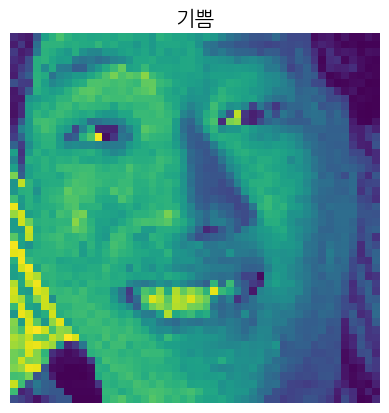

분노 : 0.02
슬픔 : 0.0
불안 : 0.01
상처 : 0.0
당황 : 0.02
기쁨 : 0.95
중립 : 0.0


In [10]:
find_and_classify(image_dir="test_images",
                  save_dir="test_images/model_inference",
                  image_filename="test23.jpg",
                  font_size=100)